# Table of Contents

1. Data Preprocessing

2. Feature Engineering

3. Model Building

4. Model Evaluation (make prediciton on the holdout dataset as well)

5. Prediction Interpretation

6. Recommendation

---

In [20]:
# import libraries
import os
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import missingno as msno
# import tensorflow as tf
# from tensorflow import keras

In [3]:
from utils import you_never_know_where_it_is

# I. Data Preprocessing

In [2]:
df = pd.read_csv('./data/loan_train.csv')

## I.1 Basic Overview Analysis

Eyeball data, check missing values, duplicates

In [7]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29777 entries, 0 to 29776
Data columns (total 52 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          29774 non-null  float64
 1   member_id                   29774 non-null  float64
 2   loan_amnt                   29774 non-null  float64
 3   funded_amnt                 29774 non-null  float64
 4   funded_amnt_inv             29774 non-null  float64
 5   term                        29774 non-null  object 
 6   int_rate                    29774 non-null  object 
 7   installment                 29774 non-null  float64
 8   grade                       29774 non-null  object 
 9   sub_grade                   29774 non-null  object 
 10  emp_title                   27955 non-null  object 
 11  emp_length                  29015 non-null  object 
 12  home_ownership              29774 non-null  object 
 13  annual_inc                  297

`Check duplicates`

In [13]:
# check duplicates
df.duplicated().sum()

# remove duplicates 
df = df.drop_duplicates()


`Check missing values`

In [26]:
# missing values as a percentage
missing_values = df.isnull().sum()
missing_values = missing_values[missing_values > 0]
missing_values = missing_values / len(df) * 100
missing_values = missing_values.sort_values(ascending=False)
missing_values.round(4)

next_pymnt_d                  92.1008
mths_since_last_record        91.3720
mths_since_last_delinq        63.4929
desc                          31.6809
emp_title                      6.1125
pub_rec_bankruptcies           3.2376
emp_length                     2.5525
chargeoff_within_12_mths       0.3426
collections_12_mths_ex_med     0.3426
tax_liens                      0.2586
last_pymnt_d                   0.2183
revol_util                     0.2183
delinq_2yrs                    0.0705
pub_rec                        0.0705
open_acc                       0.0705
acc_now_delinq                 0.0705
delinq_amnt                    0.0705
inq_last_6mths                 0.0705
total_acc                      0.0705
earliest_cr_line               0.0705
title                          0.0403
last_credit_pull_d             0.0101
annual_inc                     0.0067
out_prncp                      0.0034
loan_amnt                      0.0034
funded_amnt                    0.0034
funded_amnt_

In [19]:
# number of missing cols containing missing values
print('number of cols containing missing values:', len(missing))

# number of missing values in the loan_status 
print('number of missing values in the loan_status:', df['loan_status'].isnull().sum())

number of cols containing missing values: 51
number of missing values in the loan_status: 0


Apparently, all cols contain missing values except the label. This is quite annoying

<Axes: >

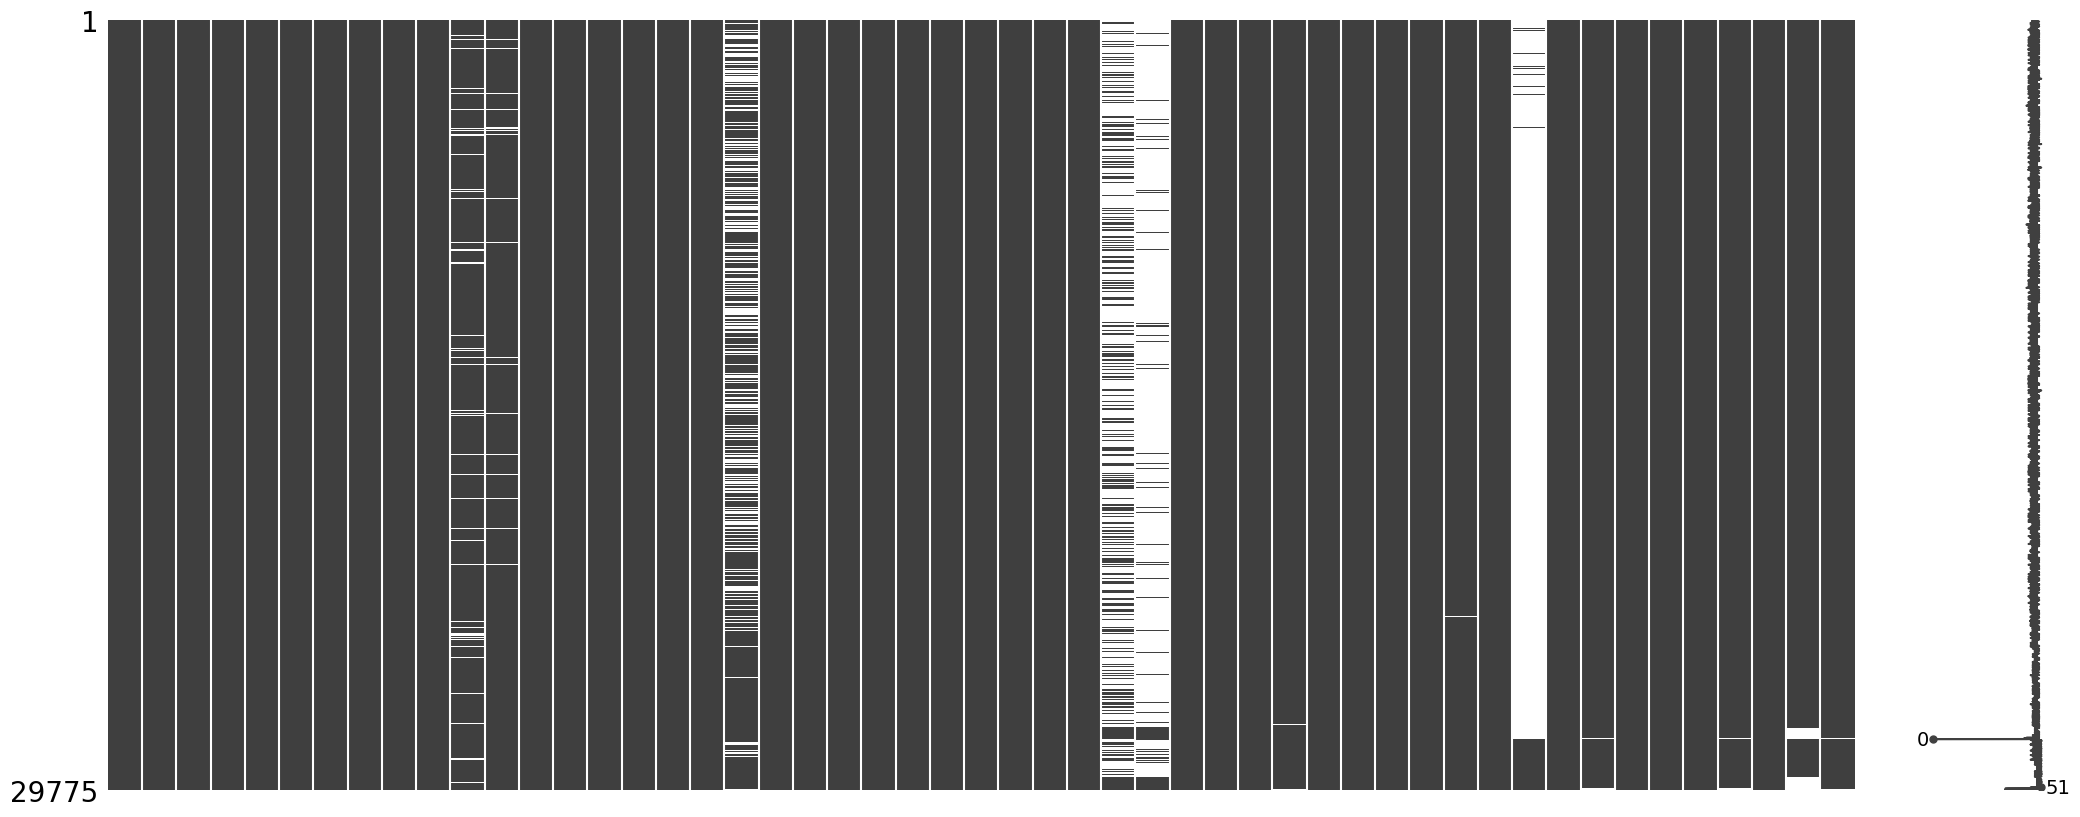

In [23]:
# check if missing values are correlated with each other 
msno.matrix(df[df.columns[df.isnull().any()]])

In [15]:
# eyeball the data
df.head(3).T

,0,1,2
id,1077501.0,1077430.0,1076863.0
member_id,1296599.0,1314167.0,1277178.0
loan_amnt,5000.0,2500.0,10000.0
funded_amnt,5000.0,2500.0,10000.0
funded_amnt_inv,4975.0,2500.0,10000.0
term,36 months,60 months,36 months
int_rate,10.65%,15.27%,13.49%
installment,162.87,59.83,339.31
grade,B,C,C
sub_grade,B2,C4,C1
